In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn import preprocessing
from e2ml.experimentation import perform_bayesian_optimization
from e2ml.preprocessing import PrincipalComponentAnalysis, StandardScaler
from sklearn.decomposition import PCA
from e2ml.experimentation import acquisition_ei, acquisition_ucb
from e2ml.models import GaussianProcessRegression
from scipy import stats

In [2]:
def loadFullData() -> pd.DataFrame:
    """
    Get full data available
    """
    initial_molluscs_data = pd.read_csv('../data/initial_molluscs_data.csv')
    full_data = initial_molluscs_data
    first_batch = pd.read_csv("../data/batch1_labels.csv")
    full_data = pd.concat((full_data, first_batch))
    second_batch = pd.read_csv("../data/batch2_labels.csv")
    full_data = pd.concat((full_data, second_batch))
    third_batch = pd.read_csv("../data/batch3_labels.csv")
    full_data = pd.concat((full_data, third_batch))
    third_batch = pd.read_csv("../data/batch3_labels.csv")
    full_data = pd.concat((full_data, third_batch))
    third_batch = pd.read_csv("../data/batch4_labels.csv")
    full_data = pd.concat((full_data, third_batch))
    return full_data


def getOneHotEncodingIndex(indicies:np.array, num_classes:int):
    """
    One hot encode data, placing the 1 at the index given in indicies

    Parameters:
        indicies: np.array of type int, list of indicies indication the class the data belongs to
        num_classes: int, number of classes (necessary if not all classes are present in the data)
    """
    #print(np.unique(indicies))
    one_hot = np.zeros((len(indicies), num_classes))
    for i, idx in enumerate(indicies):
        one_hot[i][idx] = 1
    return one_hot

def getOneHotEncoding(data:np.array, values:np.array=None):
    """
    One hot encode data

    Parameters:
        data: np.array containing the (probably categorical) data to be one-hot encoded
        values: None or np.array containing the possible values of the data. Important to ensure the data is encoded the same everytime and can be decoded acordingly
    """
    if(values == None):
        values = np.sort(np.unique(data))
    enc = np.zeros((len(data), len(values)))
    for i, x in enumerate(data):
        enc[i, np.where(values == x)[0][0]] = 1
    return enc

def reverseOneHot(data:np.array, values:np.array):
    """
    Reverse the one hot encoded data

    Parameters:
        data: np.array containing the one hot encoded data
        values: np.array containing the original values of the data. Important to ensure the data is decoded the same as the original data
    """
    enc = []
    for x in data:
        if(x[0] == 1.):
            enc.append([values[0]])
        elif(x[1] == 1.):
            enc.append([values[1]])
        elif(x[2] == 1.):
            enc.append([values[2]])    
    return np.array(enc)

def reverse_one_hot_index(indices:np.array, values:np.array):
    """
    Reverse the one hot encoded data if only the indicies of the ones is given

    Parameters:
        indicies: np.array of type int, list of indicies indication the class the data belongs to
        values: np.array containing the original values of the data. Important to ensure the data is decoded the same as the original data
    """
    enc = []
    for x in indices:
        enc.append([values[x]])    
    return np.array(enc)

def softmax(x):
    """
    implements the softmax function. Used to normalize the probabiility outputs of the models
    
    Parameters:
        x: array-like that should be normalized
    """
    x = np.array(x)
    return np.exp(x) / np.exp(x).sum(axis=1).reshape(x.shape[0],-1)

def score_cross_entropy_loss(mdl, x:np.array, y:np.array):
    """
    Calculate the cross entropy for the given model for every input
    (Note: While writting the documentation I realized that log_loss is actually only for binary cross-entropy... I think the approach still worked, but it's at least flawed :( )

    Parameters:
        x: np.array input data for the model that should be classified
        y: np.array containing the true labels of the data
    """
    if(len(y.shape) == 1):
        values = np.sort(np.unique(y))
        y = getOneHotEncoding(y, values)
    y_pred = softmax(mdl.predict_proba(x))
    #return cross_entropy_loss(y, y_pred)
    return [log_loss(y[i], y_pred[i])*-1 for i in range(len(y_pred))]


def cross_entropy_loss(y_true, y_pred):
    """
    Calculate the multiclass cross entropy for the given model for every input
    (Note: This is the function I should have used)

    Parameters:
        y_true: np.array true label either as index or onehot encoded
        y_pred: np.array containing the predicted labels of the data as probabilities
    """
    #if y contains the information of which class is true as index
    if(len(y_true.shape) == 1):
        return np.array([np.log(y_pred[i]) for i in y_true])
    #if onehot encoded
    elif(len(y_true.shape) == 2):
        return np.array([-(y_true[i] * np.log(y_pred[i])).sum() for i in range(len(y_pred))])

def objectiveFunctionRFC(x:np.array, y_rfc:np.array):
    """
    Objective function for bayesian optimization to optimize the random forest classifier
    
    Parameters:
        x: input data for the RFC
        y: labels encoded as integers of the data
    """
    rfc = RandomForestClassifier()
    rfc.fit(x,y_rfc)
    return score_cross_entropy_loss(rfc, x, y_rfc)

def objectiveFunctionSVC(x,y_rfc):
    """
    Objective function for bayesian optimization to optimize the support vector classifier
    
    Parameters:
        x: input data for the SVC
        y: labels encoded as integers of the data
    """
    svc = SVC(kernel="rbf", probability=True)
    svc.fit(x, y_rfc)
    return score_cross_entropy_loss(svc, x, y_rfc)

def objectiveFunctionMLP(x, y):
    """
    Objective function for bayesian optimization to optimize the support vector classifier
    
    Parameters:
        x: input data for the SVC
        y: labels of the data
    """
    mlp = MLPClassifier(max_iter=1000)
    mlp.fit(x,y)
    return score_cross_entropy_loss(mlp, x, y)

def getCandidates(num_x:int=150, num_y:int=150):
    """
    Function to create candidates for the bayesian optimization to evaluate and choose the next batch of data from.
    Removes already used candidates provided in the used_cands.csv to prevent using the same samples multiple times.

    Parameters:
        num_x: number of values to choose equally spaced in the first dimension
        num_y: number of values to choose equally spaced in the second dimension
    """
    x_new = np.linspace(-1, 1.5, num_x)
    y_new = np.linspace(-1, 1.5, num_y)
    x_mesh, y_mesh = np.meshgrid(x_new, y_new)
    x_cand = np.stack((x_mesh, y_mesh), axis=2).reshape(-1,2)
    used_cands_df= pd.read_csv("../data/used_cands.csv")
    used_cands = np.stack((used_cands_df["0"], used_cands_df["1"]), axis=-1)
    indices = np.zeros(used_cands.shape[0], dtype=np.int32)
    for i, value in enumerate(used_cands):
        x = np.where((np.isclose(x_cand[:,0], value[0]) & np.isclose(x_cand[:,1], value[1])))[0]
        indices[i] = int(x)
    not_used_cands = np.delete(x_cand, indices, axis=0)
    return not_used_cands

def safeUsedCands(new_used_cands):
    """
    Append the used candidates to the already used candidates in used_cands.csv

    Parameters:
        new_used_cands: Used candidiates in the current batch.
    """
    used_cands_df= pd.read_csv("../data/used_cands.csv")
    used_cands = np.stack((used_cands_df["0"], used_cands_df["1"]), axis=-1)
    all_cands = np.append(used_cands, new_used_cands, axis=0)
    used_dict = {"used_x": all_cands[:,0], "used_y": all_cands[:,1]}
    used_df = pd.DataFrame(used_dict)
    #used_df.to_csv("../data/used_cands.csv")



## **Create the second and thrid batch using bayesian optimization**
In this section I used bayesian optimization for generating the second and thrid batch.
The idea is reducing the dimensionality with pca then creating candidate values in the range that the tranformed data has.
Then use the already acquired data to fit the GaussianProcessRegression and predict the candidates that will increase the objective funtion the most.
In the second batch I did **not** standardize the data before using pca. This probably a mistake, as it is recomended to do so to ensure that the features are scaled equally as the features have different units and thus scales.
After standardizing the data the pca-transformed data looked way better than before, indicating that it is actually a good idea to use standardized data.
Standardized Data was used in the thrid batch.
One problem arising here is that by using standardized data the range of the pca-transformed data shifted to -8, 12 for teh first and -4, 4.5 for the second dimension, thus making the stored used samples useless and exposing the risk of choosing similiar data to the second batch again.
Again because of time pressure I just used what I had.
Another thing that is probably suboptimal is the way I handled the categorical data.
Since pca is not meant to be used with categorical data and cannot handle such data my first naive approach was to use the same encoding as I did for the MLP; just one-hot encoding and give the whole data to the pca.
This probably produced less meaningfull results as binary variables do not have any variance and thus screwing the pca.
It would probably have been smarter to either use some other form of dimensionality reduction or to just discart the sex feature.
Another flaw with this approach was that there were no inter molluscs in the candidates that were retransformed from the pca if used together with standardization.
When I used not standardized data in the second batch there were still inter molluscs but only 24 of the 282 were actually molluscs.
This way I got no inter molluscs in the third batch and just a few in the second batch resulting in a very scewed dataset.
I guess the best option with the tools I had at hand would have been to just leave the sex out and just choose these at random.
It is also quentionable in my oppinion if the sex has actually a meaningful impact on the stage of life as the inital data shows that every sex will reach every stage of life but that is something that would need further investigation to validate.
I also wanted to see if I could boost the performance of a specific model by using only the obejctive function of this model instead of some kind of mixture of them all (like the mean).
So in the second batch I only chose the objective function of the MLP.
After the first (random) batch the MLP with default parameters got a mean accuracy of 0.44 while the svc had 0.41 and the rfc had 0.44.
After the second (using mean of all): MLP: 0.41, SVC: 0.43, RFC: 0.45.
After the third (using only MLP): 0.48, SVC: 0.44, RFC: 0.44
The increase in the performance of the MLP could obviously be just by chance since I tried this only one time but an increase of almost 20% looked quite good.
The last interesting thing was seeing that the MLP didn't get over 50% accuracy, indicating that the distribution of stages of life was not as scewed as my data was up this point, as it would perform way better when just predicting adult and actually 74% of the molluscs would be adults.

In [3]:
full_data = loadFullData() 

y = full_data["Stage of Life"]


values = np.sort(np.unique(full_data["Sex"]))

sc = preprocessing.StandardScaler().fit(full_data.values[:,1:-1])
numeric_transf = sc.transform(full_data.values[:,1:-1])

x = np.concatenate((getOneHotEncoding(full_data["Sex"], values), numeric_transf), axis=1)

y_replaced = y.replace("Adult",0).replace("Adole",1).replace("Child",2)

pca = PCA(2)
pca = pca.fit(x)
print(pca.explained_variance_ratio_)

x_pca = pca.transform(x)
print(x_pca[:,0].max())
print(x_pca[:,1].max())
print(x_pca[:,0].min())
print(x_pca[:,1].min())

x_acquired = x_pca
y_acquired_rfc = objectiveFunctionRFC(x_acquired, y_replaced)
#print(y_acquired_rfc)
y_acquired_svc = objectiveFunctionSVC(x_acquired, y_replaced)
#print(y_acquired_svc)
y_acquired_mlp = objectiveFunctionMLP(x_acquired, y)
#print(y_acquired_mlp)

metrics_dict = {'gamma': 50, 'metric': 'rbf'}
gpr = GaussianProcessRegression(metrics_dict=metrics_dict)
gpr.fit(x_acquired, y_acquired_mlp)


x_new = np.linspace(-8, 12, 150)
y_new = np.linspace(-4, 4.5, 150)
x_mesh, y_mesh = np.meshgrid(x_new, y_new)
x_cand = np.stack((x_mesh, y_mesh), axis=2).reshape(-1,2)
means, stds = gpr.predict(x_cand, True)
scores = acquisition_ei(means, stds, max(y_acquired_mlp))
print(scores)
print(scores.mean())
print(scores.std())
print(scores.min())
print(scores.max())

nextidx = np.argsort(scores)
print("scores")
print(scores[nextidx[:282]])
print("cands")

x_new_acquired = x_cand[nextidx[:282]]
used_dict = {"used_x": x_new_acquired[:,0], "used_y": x_new_acquired[:,1]}
print(x_new_acquired)
used_df = pd.DataFrame(used_dict)
#used_df.to_csv("used_cands_batch3.csv")
print("inv pca")
new_experiments = pca.inverse_transform(x_new_acquired)
print(new_experiments[:,:3])
print(new_experiments[:,:3].shape)
print(reverseOneHot(new_experiments[:,:3], values))
print(reverseOneHot(new_experiments[:,:3], values).shape)

print(new_experiments[:,3:])
print(new_experiments[:,3:].shape)
new_experiments = np.concatenate((reverse_one_hot_index(np.argmax(new_experiments[:,:3], axis=1), values), sc.inverse_transform(new_experiments[:,3:])), axis=1)
print(new_experiments.shape)
print(new_experiments)
#new_expirments_df = pd.DataFrame(data=new_experiments, columns=full_data.columns[:-1])
new_expirments_df = pd.DataFrame(data=new_experiments.T)
print(new_expirments_df)
#new_expirments_df.to_csv("ThirdBatch.csv")
print()




[0.75692536 0.16882033]
8.997410571169148
3.5881385626790303
-5.029938356386007
-3.420685799128861
[0.59362087 0.59362087 0.59362087 ... 0.59362087 0.59362087 0.59362087]
0.5363851464820645
0.13797070138574122
1.390844866473452e-29
1.5045249720955696
scores
[1.39084487e-29 2.10553971e-27 2.46791869e-25 2.34794981e-20
 1.86779524e-19 2.62861815e-19 1.33206204e-15 2.26727216e-14
 3.10317831e-13 4.73482017e-09 1.96810861e-08 2.51300741e-07
 2.78064782e-07 3.08687783e-07 3.83957406e-07 5.40265988e-07
 1.40879261e-06 1.63213884e-06 2.62379087e-06 2.98045040e-06
 3.48317745e-06 3.89375392e-06 5.28686750e-06 6.60726321e-06
 1.16822986e-05 1.41020350e-05 2.29514843e-05 2.44367359e-05
 2.90116776e-05 3.15420828e-05 3.63074165e-05 4.52088403e-05
 4.87399441e-05 4.95169655e-05 5.06587815e-05 5.09705494e-05
 5.21607244e-05 5.76880601e-05 6.12111838e-05 6.66893247e-05
 9.68730545e-05 1.06507308e-04 1.49207551e-04 1.63619679e-04
 1.67801429e-04 2.07975613e-04 2.37485795e-04 2.77935256e-04
 3.9889846

## **Explore Data gathered in the first 3 batches**
In this section I explored the data I got from the first 3 batches to alter my approach if any anomalies showed up.
As meantioned before I found some anomalies. First was that I got very few inters in my dataset, the amount of adolescents was very low and the amount of children was extremly low ([Adult: 640, adole: 194, child: 28] and [F: 544, I: 61, M: 257])
It could be the case that this distribution of stage of life just represents the real distribution but it is still problemetic as the models could perform extremly well, by just predicting adult every time when trained on this data (74% of the data is adult)
This is also what happened unsurprisingly.
Since these anomalies were present I tried to find a way to get more children into my dataset.
This was more important to me than getting a more balanced sex distribution.

In [ ]:
#How many of each sex and stage of life are in my dataset?
full_data = loadFullData()
y = full_data["Stage of Life"]
y_replaced = y.replace("Adult",0).replace("Adole",1).replace("Child",2)

numbers_y = [np.count_nonzero(y_replaced == i) for i in range(3)]

sex = full_data["Sex"]

numbers_sex = [np.count_nonzero(sex == s) for s in ["F","I", "M"]]
print(numbers_y)
print(numbers_sex)

[187, 83, 28]
[153, 46, 99]


## **Create Data for fourth Batch**

My first Idea was to just choose small numbers for the features as children are probably small.
To do that I sampled from a normal distribution jsut as before but only kept the samples that are smaller than 1.5 times the standard deviation.
This way I only sampled from the lowest ~7% (I guess).
One mistake I made here was sampling the sexes as before but with the whole data so that the chosen sexes where also heavily scewed towards female and male (noticed while writing this documentation).
After I was done with this approach i thought of another one that I wanted to try more, described below.

In [23]:
full_data = loadFullData()
full_length = full_data["Length"]
full_width = full_data["Width"]
full_height = full_data["Height"]
full_weight = full_data["Weight"]
full_non_shell_weight = full_data["Non_Shell Weight"]
full_intestine_weight = full_data["Intestine Weight"]
full_shell_weight = full_data["Shell Weight"]
full_sexes = full_data["Sex"]
full_stages = full_data["Stage of Life"]

volume = full_length * full_width * full_height
#print(volume)
weight_volume_quotients = full_weight / volume 
non_shell_quotient = full_non_shell_weight / full_weight
intestine_quotient = full_intestine_weight / full_weight
shell_quotient = full_shell_weight / full_weight

def getNewSmallSamples(old_data:pd.Series, size:int):
    final_samples = []
    while len(final_samples) < size:
        dist = stats.norm(old_data.mean(), scale=old_data.std())
        #print(old_data.mean())
        #print(old_data.std())
        samples = dist.rvs(size=size)
        #return samples
        smalls = samples[np.where(samples < old_data.mean() - old_data.std()*1.5)[0]]
        smalls = smalls[np.where(smalls > 0)[0]]
        for small in smalls:
            final_samples.append(small)
    return np.array(final_samples[:size])

In [24]:
def getDict(size:int):
    d = {}
    d["Sex"] = np.random.choice(full_sexes, size)
    d["Length"] = getNewSmallSamples(full_length, size)
    d["Width"] = getNewSmallSamples(full_width, size)
    d["Height"] =  getNewSmallSamples(full_height, size)
    d["Weight"] = d["Height"] * d["Width"] * d["Length"] * np.random.normal(weight_volume_quotients.mean(), weight_volume_quotients.std())
    d["Non_Shell Weight"] = d["Weight"] * np.random.normal(non_shell_quotient.mean(), non_shell_quotient.std())
    d["Intestine Weight"] = d["Weight"] * np.random.normal(intestine_quotient.mean(), intestine_quotient.std())
    d["Shell Weight"] = d["Weight"] * np.random.normal(shell_quotient.mean(), shell_quotient.std())
    return d
d = getDict(336)
print(f"{d['Weight'].mean()=} {d['Weight'].std()=}")
print(f"{full_weight.mean()=} {full_weight.std()=}")
print(f"{d['Non_Shell Weight'].mean()=} {d['Non_Shell Weight'].std()=}")
print(f"{full_non_shell_weight.mean()=} {full_non_shell_weight.std()=}")
print(f"{d['Intestine Weight'].mean()=} {d['Intestine Weight'].std()=}")
print(f"{full_intestine_weight.mean()=} {full_intestine_weight.std()=}")
print(f"{d['Shell Weight'].mean()=} {d['Shell Weight'].std()=}")
print(f"{full_shell_weight.mean()=} {full_shell_weight.std()=}")
orignial_diffs = full_weight - full_intestine_weight - full_non_shell_weight - full_shell_weight
new_diffs = d["Weight"] - d["Intestine Weight"] - d["Non_Shell Weight"] - d["Shell Weight"]
#print(orignial_diffs)
#print(new_diffs)
print(f"{orignial_diffs.mean()=} {orignial_diffs.std()=}")
print(f"{new_diffs.mean()=} {new_diffs.std()=}")
print(pd.DataFrame(d))

d['Weight'].mean()=0.03159178096845777 d['Weight'].std()=0.01275268269387315
full_weight.mean()=0.5986524367914604 full_weight.std()=0.3579823315067823
d['Non_Shell Weight'].mean()=0.008187364883483863 d['Non_Shell Weight'].std()=0.0033050009609232383
full_non_shell_weight.mean()=0.2436711807598871 full_non_shell_weight.std()=0.1474241991979075
d['Intestine Weight'].mean()=0.0054352322827987696 d['Intestine Weight'].std()=0.0021940451137982243
full_intestine_weight.mean()=0.11968673090907464 full_intestine_weight.std()=0.07246670713080836
d['Shell Weight'].mean()=0.012211457572884964 d['Shell Weight'].std()=0.004929410083343539
full_shell_weight.mean()=0.18759589222122275 full_shell_weight.std()=0.11024784433704393
orignial_diffs.mean()=0.047698632901275996 orignial_diffs.std()=0.02833632041776454
new_diffs.mean()=0.005757726229290179 new_diffs.std()=0.0023242265358081474
    Sex    Length     Width    Height    Weight  Non_Shell Weight  \
0     F  0.232860  0.169680  0.056505  0.02170

In [ ]:
new_expirments_df = pd.DataFrame(d)
#new_expirments_df.to_csv("FourthBatchBen.csv")

## **Second approach to getting children**
The second idea I had was again choosing some candidates from the pca-space, then retransforming them into the orginal feature space (with sexes being samples randomly) and then using those as inputs into the MLP (best performing model at that time).
Then by getting the probabilities of the outputs I sortet the inputs by chance of the input being children and taking the first 236.
Together with another hundred where I did the same but for adolescent (as I also had only a few of them) I obtained the final batch.
Unluckyly since I didn't use the sex feature in the pca it was possible again, that I chose the same samples as before as I couldn't filter out the cands I already used.
**NOTE**
As I just found out while writing the rest of the documentation I handed in the wrong file for the final batch :)
I think it was an early file I made with the first appraoch, but since it also contains negative values and can't be the final version.
However the approach seemed to work as most of the data was labeled as child or adolescent.
I'm actually surprised the divers found molluscs with negative features like weight or length but since I got results that way im happy with that.
Unfortunately I can't tell whether or not the second approach would have worked, so this is just theoretical.
The batch I wanted to hand in (I think) is the one also in this git named FourthBatchBen.csv 

In [105]:
full_data = loadFullData()
y = full_data["Stage of Life"]
y_replaced = y.replace("Adult",0).replace("Adole",1).replace("Child",2)

values = np.sort(np.unique(full_data["Sex"]))

sc = preprocessing.StandardScaler().fit(full_data.values[:,1:-1])
numeric_transf = sc.transform(full_data.values[:,1:-1])

x = np.concatenate((getOneHotEncoding(full_data["Sex"], values), numeric_transf), axis=1)

pca = PCA(2)
pca = pca.fit(numeric_transf)
print(pca.explained_variance_ratio_)

x_pca = pca.transform(numeric_transf)

mlp = MLPClassifier(max_iter=1000)
mlp.fit(x, y)

svc = SVC(kernel="rbf", probability=True)
svc.fit(x, y_replaced)

rfc = RandomForestClassifier()
rfc.fit(x,y_replaced)

[0.93971634 0.0359706 ]


RandomForestClassifier()

In [106]:
x_new = np.linspace(-8, 12, 150)
y_new = np.linspace(-4, 4.5, 150)
x_mesh, y_mesh = np.meshgrid(x_new, y_new)
x_cand = np.stack((x_mesh, y_mesh), axis=2).reshape(-1,2)

x_cand_raw = pca.inverse_transform(x_cand)

x_cand = np.concatenate((getOneHotEncodingIndex(np.argmax(np.random.uniform(size=(x_cand_raw.shape[0],3)), axis=1), 3), sc.inverse_transform(x_cand_raw)), axis=1)
#x_cand = np.concatenate((np.zeros(shape=(x_cand_raw.shape[0], 3)), sc.inverse_transform(x_cand_raw)), axis=1)

print(svc.classes_)
probs = svc.predict_proba(x_cand)
print(probs)
print(rfc.classes_)
probs = rfc.predict_proba(x_cand)
print(probs)

print(mlp.classes_)
probs = mlp.predict_proba(x_cand)
print(probs)

[0 1 2]
[[0.44158308 0.37951905 0.17889787]
 [0.44169249 0.37942254 0.17888496]
 [0.43187133 0.39291036 0.17521831]
 ...
 [0.53043406 0.2462762  0.22328974]
 [0.53081063 0.24564357 0.22354579]
 [0.4850733  0.29914139 0.21578531]]
[0 1 2]
[[0.45 0.18 0.37]
 [0.45 0.18 0.37]
 [0.47 0.12 0.41]
 ...
 [0.2  0.8  0.  ]
 [0.2  0.8  0.  ]
 [0.4  0.6  0.  ]]
['Adole' 'Adult' 'Child']
[[3.00859519e-01 4.65615259e-03 6.94484329e-01]
 [2.88502896e-01 5.19355414e-03 7.06303550e-01]
 [7.49004388e-02 6.83183473e-04 9.24416378e-01]
 ...
 [9.74121181e-01 2.57610914e-02 1.17727772e-04]
 [9.70341660e-01 2.95391644e-02 1.19175252e-04]
 [4.49282710e-03 9.95409921e-01 9.72522010e-05]]


In [107]:
only_child = probs[:,2]
idx = np.argsort(-only_child)
print(only_child[idx])

first_cands = x_cand[idx][:236]

[9.99909228e-01 9.99907338e-01 9.99898247e-01 ... 4.37805284e-08
 4.12776449e-08 3.96112942e-08]


In [108]:
only_adole = probs[:,1]
idx = np.argsort(-only_adole)
print(only_adole[idx])
second_cands = x_cand[idx][:100]
#print(second_cands)

[9.99999948e-01 9.99999946e-01 9.99999941e-01 ... 2.89767972e-09
 2.78096075e-09 2.17707244e-09]


In [109]:
full_cands = np.append(first_cands, second_cands, axis=0)
print(len(full_cands))

336


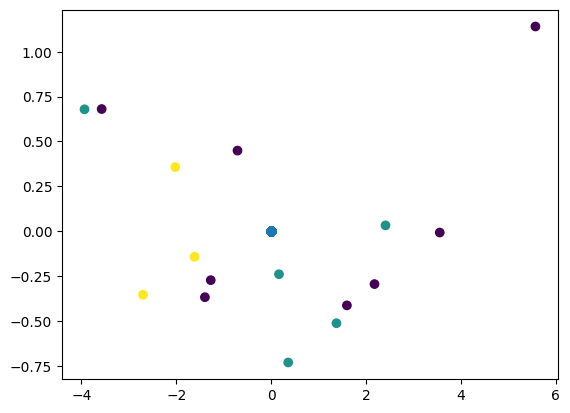

In [115]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=y_replaced)
plt.scatter(full_cands[:,0], full_cands[:,1])
plt.show()

In [120]:
print(full_cands)
new_experiments = np.concatenate((reverse_one_hot_index(np.argmax(np.random.uniform(size=(full_cands.shape[0],3)), axis=1), values), sc.inverse_transform(full_cands[:,3:])), axis=1)
new_expirments_df = pd.DataFrame(data=new_experiments, columns=full_data.columns[:-1])
print(new_expirments_df)


[[ 0.          0.          1.         ...  0.60604209  0.37346656
   0.63730925]
 [ 0.          0.          1.         ...  0.59521108  0.3680769
   0.63056204]
 [ 0.          0.          1.         ...  0.59641259  0.36660197
   0.62438667]
 ...
 [ 0.          0.          1.         ... -0.80201537 -0.35518495
  -0.33331713]
 [ 0.          0.          1.         ... -0.81764374 -0.34534285
  -0.28420009]
 [ 0.          0.          1.         ... -0.81884526 -0.34386791
  -0.27802472]]
    Sex              Length                Width               Height  \
0     I  0.6727114971756144   0.5125754244156385  0.15644401527301774   
1     F  0.6719891896417045   0.5120425585828625  0.15636283907912804   
2     F  0.6703687695282086   0.5110518472460175  0.15622983974579754   
3     M  0.6699197132384156   0.5108229244939829  0.15620392817607714   
4     F  0.6700955182840918    0.510747904165276  0.15617457512162825   
..   ..                 ...                  ...                  ...  

In [46]:
"""
This is just older version of the code, can be ignored, but I kept it in as I didn't want to delete anything in case I need that for preparing for the oral exam :)
"""
x_new_acquired = full_cands
used_dict = {"used_x": x_new_acquired[:,0], "used_y": x_new_acquired[:,1]}
print(x_new_acquired)
used_df = pd.DataFrame(used_dict)
#used_df.to_csv("used_cands_batch4.csv")
print("inv pca")
new_experiments = pca.inverse_transform(x_new_acquired)
print(new_experiments[:,:3])
print(new_experiments[:,:3].shape)
print(reverseOneHot(new_experiments[:,:3], values))
print(reverseOneHot(new_experiments[:,:3], values).shape)

print(new_experiments[:,3:])
print(new_experiments[:,3:].shape)
new_experiments = np.concatenate((reverse_one_hot_index(np.argmax(new_experiments[:,:3], axis=1), values), sc.inverse_transform(new_experiments[:,3:])), axis=1)
print(new_experiments.shape)
print(new_experiments)
new_expirments_df = pd.DataFrame(data=new_experiments, columns=full_data.columns[:-1])
#new_expirments_df = pd.DataFrame(data=new_experiments.T)
print(new_expirments_df)
#new_expirments_df.to_csv("FourthBatch.csv")

[[-3.03355705  1.93288591]
 [-2.76510067  1.93288591]
 [-2.89932886  1.93288591]
 [-2.09395973  2.21812081]
 [-3.03355705  1.87583893]
 [-4.37583893 -2.80201342]
 [-4.37583893 -2.8590604 ]
 [-4.37583893 -2.91610738]
 [-3.83892617  0.84899329]
 [-4.37583893 -2.97315436]
 [-4.37583893 -3.03020134]
 [-6.12080537 -2.97315436]
 [-6.12080537 -2.8590604 ]
 [-3.83892617  0.90604027]
 [-6.25503356 -2.8590604 ]
 [-6.52348993 -2.97315436]
 [-6.12080537 -2.80201342]
 [-6.25503356 -2.80201342]
 [-6.38926174 -2.80201342]
 [-6.52348993 -2.80201342]
 [-6.38926174 -2.97315436]
 [-6.25503356 -2.97315436]
 [-6.38926174 -2.8590604 ]
 [-6.52348993 -2.91610738]
 [-6.38926174 -2.91610738]
 [-2.76510067  1.87583893]
 [-6.12080537 -2.91610738]
 [-6.25503356 -2.91610738]
 [-6.52348993 -2.8590604 ]
 [-2.36241611  2.21812081]
 [-6.52348993 -3.03020134]
 [-6.38926174 -3.03020134]
 [-2.89932886  1.87583893]
 [-6.25503356 -3.03020134]
 [-3.70469799  0.84899329]
 [-6.12080537 -3.03020134]
 [ 6.63087248  0.50671141]
 

[[ 1.          0.          0.         ... -1.21641639 -0.94720341
  -1.14265086]
 [ 1.          0.          0.         ... -1.20194939 -0.49569798
  -0.47090362]
 [ 0.          0.          1.         ...  1.22850674  1.90905916
   1.76394777]
 ...
 [ 0.          0.          1.         ... -0.25053149 -0.24235763
  -0.24281549]
 [ 1.          0.          0.         ...  0.27155386  0.27704853
   0.27185656]
 [ 0.          0.          1.         ... -0.29349563 -0.28501577
  -0.28511794]]
(580, 10)
[0.69096185 0.11797633]
[54.99610122 22.72491743]
11.697543430954404
3.9241258731927884
-7.729254717549433
-3.509708334680696


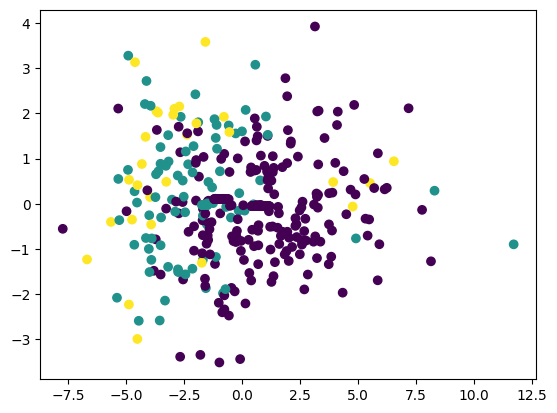

In [77]:
"""
Just some visual representation of the data I wanted to make, to see if the data would be seperable in the 2D-pca-subspace
"""

values = np.sort(np.unique(full_data["Sex"]))

sc = preprocessing.StandardScaler().fit(full_data.values[:,1:-1])
numeric_transf = sc.transform(full_data.values[:,1:-1])

x = np.concatenate((getOneHotEncoding(full_data["Sex"], values), numeric_transf), axis=1)
print(x)

print(x.shape)
#print(x_full_replaced)

pca = PCA(2)
pca = pca.fit(x)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

x_pca = pca.transform(x)
print(x_pca[:,0].max())
print(x_pca[:,1].max())
print(x_pca[:,0].min())
print(x_pca[:,1].min())

plt.scatter(x_pca[:,0], x_pca[:,1], c=y_replaced)
plt.show()

Was ich am 6.7. gelernt habe:
1. Mein Datensatz besteht aus [640, 194, 28] [Adult, adole, child] und [544, 61, 257] [F, I, M]
2. Wenn man die PCA von allen Cands vom Standartisierten Datensatz zurück transformiert, gibt es keine Inter mehr. (Davor anscheinend schon, scheint was mit der standartisierung zu tun zu haben)
3. Wenn man das MLP auf den daten dieser Kandidaten im original format (inverse pca) trainiert gibt es einfach immer Adult aus (~99%).

Dinge davor:
1. Alles normalverteilt
2. Scuffed Pca mit onehot ohne standartisierung -> baysian optimization for mlp -> reverse
3. Scuffed PCA mit onehot und standartisierung -> baysian optimization for mlp -> reverse
4. ? 

Sexes sollten keinen EInfluss auf das Ergebnis haben (glaube ich). Zumindest sollten sie nicht ausschlaggebend sein.